# ETL of air pollution time series
## The deliverables
Data set containing all available recordings of hourly averaged pollutant concentrations measured in Hamburg in years 2013-2019

In [1]:
import urllib.request
import xml.etree.ElementTree as ET
from lxml import etree
import pandas as pd
import numpy as np

import re, collections
from io import StringIO
import os, fnmatch

import matplotlib.pyplot as plt

import geopandas as gpd
import mplleaflet

import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

%matplotlib inline

In [2]:
## Download and decompress the dataset (2019) itself:
#!mkdir Correlaid.rawData
#!mkdir Correlaid.rawData/AQD_DE_E1a_2019
#!ls -l Correlaid.rawData/
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2019.zip", "Correlaid.rawData/AQD_DE_E1a_2019.zip")
#!mv Correlaid.rawData/AQD_DE_E1a_2019.zip Correlaid.rawData/AQD_DE_E1a_2019/
#!unzip Correlaid.rawData/AQD_DE_E1a_2019/AQD_DE_E1a_2019.zip -d Correlaid.rawData/
#!rm Correlaid.rawData/AQD_DE_E1a_2019/AQD_DE_E1a_2019.zip
#!unzip Correlaid.rawData/DISKO.zip -d Correlaid.rawData/AQD_DE_E1a_2019/
#!unzip Correlaid.rawData/KONTI.zip -d Correlaid.rawData/AQD_DE_E1a_2019/
#!rm Correlaid.rawData/DISKO.zip Correlaid.rawData/KONTI.zip

#Download the rdf
#urllib.request.urlretrieve("https://www.govdata.de/ckan/dataset/luftqualitatsdaten-datenstrom-e1a-validierte-einzelwerte-2019-datensatz.rdf", "Correlaid.rawData/AQD_DE_E1a_2019/luftqualitatsdaten-datenstrom-e1a-validierte-einzelwerte-2019-datensatz.rdf")

#Download Sensor positions
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_D_2019.zip", "Correlaid.rawData/AQD_DE_D_2019.zip")
#!unzip Correlaid.rawData/AQD_DE_D_2019.zip -d Correlaid.rawData/
#!rm Correlaid.rawData/AQD_DE_D_2019.zip

# Download Town-county dataset:
#urllib.request.urlretrieve("https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/Archiv/GV100ADQ/GV100AD3107.zip?__blob=publicationFile",
#                           "Correlaid.rawData/GV100AD3107.zip")
#!mkdir Correlaid.rawData/GV100AD3107
#!unzip Correlaid.rawData/GV100AD3107.zip -d Correlaid.rawData/GV100AD3107/
#!rm Correlaid.rawData/GV100AD3107.zip

#!mkdir Correlaid.rawData/Geo
#urllib.request.urlretrieve("https://biogeo.ucdavis.edu/data/diva/adm/DEU_adm.zip", "Correlaid.rawData/Geo/DEU_adm.zip" 
#!unzip Correlaid.rawData/Geo/DEU_adm.zip -d Correlaid.rawData/Geo/

#!ls -la Correlaid.rawData/
#!ls -la Correlaid.rawData/AQD_DE_E1a_2019/
#!ls -la Correlaid.rawData/GV100AD3107/

#!pwd

In [3]:
#Download and decompress the dataset (2018) itself:
#!mkdir Correlaid.rawData/AQD_DE_E1a_2018
#!ls -l Correlaid.rawData/
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2018.zip", "Correlaid.rawData/AQD_DE_E1a_2018.zip")
#!mv Correlaid.rawData/AQD_DE_E1a_2018.zip Correlaid.rawData/AQD_DE_E1a_2018/
#!unzip Correlaid.rawData/AQD_DE_E1a_2018/AQD_DE_E1a_2018.zip -d Correlaid.rawData/
#!rm Correlaid.rawData/AQD_DE_E1a_2018/AQD_DE_E1a_2018.zip
#!mv Correlaid.rawData/E1a/* Correlaid.rawData/AQD_DE_E1a_2018/
#!rm -rf Correlaid.rawData/E1a

In [4]:
#Download and decompress the dataset (2017) itself:
#!mkdir Correlaid.rawData/AQD_DE_E1a_2017
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2017.zip", "Correlaid.rawData/AQD_DE_E1a_2017.zip")
#!mv Correlaid.rawData/AQD_DE_E1a_2017.zip Correlaid.rawData/AQD_DE_E1a_2017/
#!unzip Correlaid.rawData/AQD_DE_E1a_2017/AQD_DE_E1a_2017.zip -d Correlaid.rawData/
#!rm Correlaid.rawData/AQD_DE_E1a_2017/AQD_DE_E1a_2017.zip
#!unzip Correlaid.rawData/AQD_DE_E1a_2017/DISKO.zip -d Correlaid.rawData/AQD_DE_E1a_2017/
#!unzip Correlaid.rawData/AQD_DE_E1a_2017/KONTI.zip -d Correlaid.rawData/AQD_DE_E1a_2017/
#!rm Correlaid.rawData/AQD_DE_E1a_2017/DISKO.zip Correlaid.rawData/AQD_DE_E1a_2017/KONTI.zip


In [5]:
#Download and decompress the dataset (2016) itself:
#!mkdir Correlaid.rawData/AQD_DE_E1a_2016
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2016.zip", "Correlaid.rawData/AQD_DE_E1a_2016.zip")
#!mv Correlaid.rawData/AQD_DE_E1a_2016.zip Correlaid.rawData/AQD_DE_E1a_2016/
#!unzip Correlaid.rawData/AQD_DE_E1a_2016/AQD_DE_E1a_2016.zip -d Correlaid.rawData/
#!rm Correlaid.rawData/AQD_DE_E1a_2016/AQD_DE_E1a_2016.zip

#  !!!!!!!!!! No data for Hamburg available here !!!!!!!!!!

In [6]:
#Download and decompress the dataset (2015) itself:
#!mkdir Correlaid.rawData/AQD_DE_E1a_2015
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2015.zip", "Correlaid.rawData/AQD_DE_E1a_2015.zip")
#!mv Correlaid.rawData/AQD_DE_E1a_2015.zip Correlaid.rawData/AQD_DE_E1a_2015/
#!unzip Correlaid.rawData/AQD_DE_E1a_2015/AQD_DE_E1a_2015.zip -d Correlaid.rawData/
#!rm Correlaid.rawData/AQD_DE_E1a_2015/AQD_DE_E1a_2015.zip


In [7]:
#Download and decompress the dataset (2014) itself:
#!mkdir Correlaid.rawData/AQD_DE_E1a_2014
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2014.zip", "Correlaid.rawData/AQD_DE_E1a_2014.zip")
#!mv Correlaid.rawData/AQD_DE_E1a_2014.zip Correlaid.rawData/AQD_DE_E1a_2014/
#!unzip Correlaid.rawData/AQD_DE_E1a_2014/AQD_DE_E1a_2014.zip -d Correlaid.rawData/
#!rm Correlaid.rawData/AQD_DE_E1a_2014/AQD_DE_E1a_2014.zip


In [8]:
#Download and decompress the dataset (2013) itself:
#!mkdir Correlaid.rawData/AQD_DE_E1a_2013
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2013.zip", "Correlaid.rawData/AQD_DE_E1a_2013.zip")
#!mv Correlaid.rawData/AQD_DE_E1a_2013.zip Correlaid.rawData/AQD_DE_E1a_2013/
#!unzip Correlaid.rawData/AQD_DE_E1a_2013/AQD_DE_E1a_2013.zip -d Correlaid.rawData/
#!rm Correlaid.rawData/AQD_DE_E1a_2013/AQD_DE_E1a_2013.zip


In [9]:
def etl_concentrations_timeseries_from_file(input_file):
    # pick all tags from the XML file
    Etree = ET.parse(input_file)
    Eroot = Etree.getroot()
    Eroot.tag
    Eroot.attrib
    AllTags = [elem.tag for elem in Eroot.iter()]
  
    varFull = [s for s in AllTags if 'value' in s][0]
    ColNamesExp = [re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) for varr in Eroot.iter(varFull) if 'AQD' in str(varr.attrib)] 

    
    varFull = [s for s in AllTags if 'values' in s][0]

    dff=[]
    for varr in Eroot.iter(varFull):
        dff.append(pd.read_csv(StringIO((varr.text).replace("@@","\n")), sep=",", header=None))
    
    out_df=pd.concat([dff[s][4] for s in range(0,len(dff))], axis=1)
    out_df.columns=ColNamesExp
    out_df.insert(loc=0, column="observation_period", value=dff[0][0])
    return(out_df)    

def etl_concentrations_timeseries_from_dir_and_mask(input_dir, file_mask):
    files_hour = []
    for file in os.listdir(input_dir):
        if fnmatch.fnmatch(file, file_mask):
            files_hour.append(file)

    # pick all tags from the XML file
    Etree = ET.parse(input_dir + files_hour[0])
    Eroot = Etree.getroot()
    Eroot.tag
    Eroot.attrib
    AllTags = [elem.tag for elem in Eroot.iter()]

#    ColNamesExp=SelectAllXMLsensorID(AllTags)
    varFull = [s for s in AllTags if 'values' in s][0]

    dff=[]
    for varr in Eroot.iter(varFull):
        dff.append(pd.read_csv(StringIO((varr.text).replace("@@","\n")), sep=",", header=None))

    out_df = dff[0][[0]]
    out_df.columns=['observation_period']

# get all tags in xml file; Note, that the actual data is kept as a TEXT of *values* tags 
    for file in files_hour:
        Etree = ET.parse(input_dir + file)
        Eroot = Etree.getroot()
        Eroot.tag
        Eroot.attrib
        AllTags = [elem.tag for elem in Eroot.iter()]
           
        varFull = [s for s in AllTags if 'value' in s][0]
        ColNamesExp = [re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) for varr in Eroot.iter(varFull) if 'AQD' in str(varr.attrib)] 

        
        # Compare column names with file names, they should encode same country, state and pollutant
        for ColName in ColNamesExp:
            if ((ColName[0:2]!=file[0:2]) or (ColName[2:4]!=file[3:5]) or (ColName[8:11]!=file[11:14])):
                print("Inconsistency in file and column names: ", file, ColName)
                exit()
    
        varFull = [s for s in AllTags if 'values' in s][0]
    
        dff=[] # Temporary list for DataFrames
        # reading actual pollutant data fiom the text field:    
        for varr in Eroot.iter(varFull):
            dff.append(pd.read_csv(StringIO((varr.text).replace("@@","\n")), sep=",", header=None))

        # checking, that measurment timestamps are identical in the files read    
        bad_s = []
        for s in range(0,len(dff)):
            if not (out_df['observation_period']).equals(dff[s][0]):
                print("Inconsistency of observation times in the following files: ", file, files_hour[0])
                print(out_df['observation_period'])
                print(dff[s][0])
                print(s)
                print(ColNamesExp[s])
                bad_s.append(s) 
                
#                exit()

        for s in bad_s:
            del ColNamesExp[s]
            del dff[s]

        # select column 4 - pollutant concentration:
        dff=pd.concat([dff[s][4] for s in range(0,len(dff))], axis=1)
        dff.columns=ColNamesExp
   
        out_df=pd.concat([out_df, dff], axis=1)    
#    out_df=pd.concat([dff[s][4] for s in range(0,len(dff))], axis=1)
#    out_df.columns=ColNamesExp
#    out_df.insert(loc=0, column="observation_period", value=dff[0][0])
    return(out_df)    

In [10]:
wide_df19 = etl_concentrations_timeseries_from_file("Correlaid.rawData/AQD_DE_E1a_2019/DE_HH_2019_hour.xml")

Now we have wide data frame, containing timeseries of all pollutant concentrations for all sensors. The pollutant type and the sensor ID are encoded in column names. The minimal value of pollutant concentrations -999.0 is equivalent to NA and will be imputted, as well as all negative values (the concentration can not be negative). The limit for imputation will be set to 876, i.e. NA sequences exceeding 10% of the year will not be imputted. Since the number of heavily corrupted columns is below 2%, they will be dropped in favor to the information quality:

In [11]:
wide_df19.head(5)

,observation_period,DEHH068_CHB_dataGroup1,DEHH070_CHB_dataGroup1,DEHH008_NO2_dataGroup1,DEHH015_NO2_dataGroup1,DEHH016_NO2_dataGroup1,DEHH026_NO2_dataGroup1,DEHH033_NO2_dataGroup1,DEHH047_NO2_dataGroup1,DEHH050_NO2_dataGroup1,...,DEHH016_SO2_dataGroup1,DEHH059_SO2_dataGroup1,DEHH079_SO2_dataGroup1,DEHH081_SO2_dataGroup1,DEHH008_PM2_dataGroup1,DEHH015_PM2_dataGroup1,DEHH033_PM2_dataGroup1,DEHH059_PM2_dataGroup1,DEHH064_PM2_dataGroup1,DEHH068_PM2_dataGroup1
0,2019-01-01T00:00:00+01:00,2.182,0.977,23.896,16.787,13.292,30.217,14.883,13.441,10.037,...,2.500,2.5,2.5,2.500,98.733,116.412,51.636,88.387,216.470,602.380
1,2019-01-01T01:00:00+01:00,0.693,0.773,13.698,11.791,16.222,19.486,6.349,6.496,4.000,...,2.500,2.5,2.5,9.531,33.534,96.405,75.457,65.468,161.832,80.708
2,2019-01-01T02:00:00+01:00,0.454,0.675,7.991,6.998,15.669,12.586,6.243,4.708,2.000,...,2.500,2.5,2.5,11.270,24.592,25.195,15.651,13.072,18.958,36.882
3,2019-01-01T03:00:00+01:00,0.200,-999.000,7.322,5.273,14.999,12.025,4.714,4.130,2.000,...,2.500,2.5,2.5,2.500,22.920,16.258,11.641,12.416,13.909,36.853
4,2019-01-01T04:00:00+01:00,-999.000,-999.000,6.211,5.665,13.821,9.234,5.180,2.000,2.000,...,5.926,2.5,2.5,2.500,30.757,19.862,15.598,17.161,17.068,47.537


In [12]:
def clean_wide_df(df):
    out_df = df.copy()
    df_observation_period = out_df["observation_period"]
    out_df.drop(["observation_period"], axis=1, inplace=True)
    out_df[out_df.loc[:, out_df.columns != 'observation_period'] < 0.0] = np.NaN # concentration cannot be negative
    out_df.interpolate(method='linear', inplace=True, axis=0, limit=876, limit_direction='both')
    out_df.insert(loc=0, column="observation_period", value=pd.to_datetime(df_observation_period))
    out_df.dropna(axis=1, inplace=True)
    out_df = out_df.set_index("observation_period")
    return(out_df)

In [13]:
clean_df19 = clean_wide_df(wide_df19)

In [14]:
clean_df19

,DEHH008_NO2_dataGroup1,DEHH015_NO2_dataGroup1,DEHH016_NO2_dataGroup1,DEHH026_NO2_dataGroup1,DEHH033_NO2_dataGroup1,DEHH047_NO2_dataGroup1,DEHH050_NO2_dataGroup1,DEHH059_NO2_dataGroup1,DEHH064_NO2_dataGroup1,DEHH068_NO2_dataGroup1,...,DEHH016_SO2_dataGroup1,DEHH059_SO2_dataGroup1,DEHH079_SO2_dataGroup1,DEHH081_SO2_dataGroup1,DEHH008_PM2_dataGroup1,DEHH015_PM2_dataGroup1,DEHH033_PM2_dataGroup1,DEHH059_PM2_dataGroup1,DEHH064_PM2_dataGroup1,DEHH068_PM2_dataGroup1
observation_period,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00+01:00,23.896,16.787,13.292,30.217,14.883,13.441,10.037,12.743,26.956,34.375,...,2.500,2.500,2.5,2.500,98.733,116.412,51.636,88.387,216.470,602.380
2019-01-01 01:00:00+01:00,13.698,11.791,16.222,19.486,6.349,6.496,4.000,6.534,21.644,20.793,...,2.500,2.500,2.5,9.531,33.534,96.405,75.457,65.468,161.832,80.708
2019-01-01 02:00:00+01:00,7.991,6.998,15.669,12.586,6.243,4.708,2.000,7.821,19.521,16.449,...,2.500,2.500,2.5,11.270,24.592,25.195,15.651,13.072,18.958,36.882
2019-01-01 03:00:00+01:00,7.322,5.273,14.999,12.025,4.714,4.130,2.000,4.483,11.384,13.806,...,2.500,2.500,2.5,2.500,22.920,16.258,11.641,12.416,13.909,36.853
2019-01-01 04:00:00+01:00,6.211,5.665,13.821,9.234,5.180,2.000,2.000,4.407,9.204,11.069,...,5.926,2.500,2.5,2.500,30.757,19.862,15.598,17.161,17.068,47.537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+01:00,18.548,54.225,22.169,47.611,31.095,27.900,8.188,35.967,37.350,57.787,...,2.500,6.883,2.5,2.500,21.517,13.039,22.387,38.361,23.008,185.311
2019-12-31 20:00:00+01:00,29.200,53.365,54.761,43.915,27.776,37.072,12.948,31.421,58.767,54.685,...,2.500,8.485,2.5,2.500,49.821,16.909,32.743,29.221,35.980,98.057
2019-12-31 21:00:00+01:00,38.042,52.547,66.944,49.817,24.601,32.879,14.205,29.640,61.504,44.541,...,2.500,9.448,2.5,2.500,62.207,28.918,36.081,63.075,63.972,122.113


In [15]:
wide_df18 = etl_concentrations_timeseries_from_dir_and_mask("Correlaid.rawData/AQD_DE_E1a_2018/", "DE_HH*hour*")

Inconsistency of observation times in the following files:  DE_HH_2018_PM2_hour.xml DE_HH_2018_O3_hour.xml
0       2018-01-01T00:00:00+01:00
1       2018-01-01T01:00:00+01:00
2       2018-01-01T02:00:00+01:00
3       2018-01-01T03:00:00+01:00
4       2018-01-01T04:00:00+01:00
                  ...            
8755    2018-12-31T19:00:00+01:00
8756    2018-12-31T20:00:00+01:00
8757    2018-12-31T21:00:00+01:00
8758    2018-12-31T22:00:00+01:00
8759    2018-12-31T23:00:00+01:00
Name: observation_period, Length: 8760, dtype: object
0       2018-04-01T00:00:00+01:00
1       2018-04-01T01:00:00+01:00
2       2018-04-01T02:00:00+01:00
3       2018-04-01T03:00:00+01:00
4       2018-04-01T04:00:00+01:00
                  ...            
5851    2018-11-30T19:00:00+01:00
5852    2018-11-30T20:00:00+01:00
5853    2018-11-30T21:00:00+01:00
5854    2018-11-30T22:00:00+01:00
5855    2018-11-30T23:00:00+01:00
Name: 0, Length: 5856, dtype: object
2
DEHH033_PM2_dataGroup1


In [16]:
clean_df18 = clean_wide_df(wide_df18)

In [17]:
clean_df19.head(5)

,DEHH008_NO2_dataGroup1,DEHH015_NO2_dataGroup1,DEHH016_NO2_dataGroup1,DEHH026_NO2_dataGroup1,DEHH033_NO2_dataGroup1,DEHH047_NO2_dataGroup1,DEHH050_NO2_dataGroup1,DEHH059_NO2_dataGroup1,DEHH064_NO2_dataGroup1,DEHH068_NO2_dataGroup1,...,DEHH016_SO2_dataGroup1,DEHH059_SO2_dataGroup1,DEHH079_SO2_dataGroup1,DEHH081_SO2_dataGroup1,DEHH008_PM2_dataGroup1,DEHH015_PM2_dataGroup1,DEHH033_PM2_dataGroup1,DEHH059_PM2_dataGroup1,DEHH064_PM2_dataGroup1,DEHH068_PM2_dataGroup1
observation_period,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00+01:00,23.896,16.787,13.292,30.217,14.883,13.441,10.037,12.743,26.956,34.375,...,2.500,2.5,2.5,2.500,98.733,116.412,51.636,88.387,216.470,602.380
2019-01-01 01:00:00+01:00,13.698,11.791,16.222,19.486,6.349,6.496,4.000,6.534,21.644,20.793,...,2.500,2.5,2.5,9.531,33.534,96.405,75.457,65.468,161.832,80.708
2019-01-01 02:00:00+01:00,7.991,6.998,15.669,12.586,6.243,4.708,2.000,7.821,19.521,16.449,...,2.500,2.5,2.5,11.270,24.592,25.195,15.651,13.072,18.958,36.882
2019-01-01 03:00:00+01:00,7.322,5.273,14.999,12.025,4.714,4.130,2.000,4.483,11.384,13.806,...,2.500,2.5,2.5,2.500,22.920,16.258,11.641,12.416,13.909,36.853
2019-01-01 04:00:00+01:00,6.211,5.665,13.821,9.234,5.180,2.000,2.000,4.407,9.204,11.069,...,5.926,2.5,2.5,2.500,30.757,19.862,15.598,17.161,17.068,47.537


In [18]:
clean_df18

,DEHH008_O3_dataGroup1,DEHH033_O3_dataGroup1,DEHH047_O3_dataGroup1,DEHH050_O3_dataGroup1,DEHH008_NO2_dataGroup1,DEHH015_NO2_dataGroup1,DEHH016_NO2_dataGroup1,DEHH026_NO2_dataGroup1,DEHH033_NO2_dataGroup1,DEHH047_NO2_dataGroup1,...,DEHH033_CO_dataGroup1,DEHH068_CO_dataGroup1,DEHH070_CO_dataGroup1,DEHH008_PM2_dataGroup1,DEHH015_PM2_dataGroup1,DEHH059_PM2_dataGroup1,DEHH064_PM2_dataGroup1,DEHH068_PM2_dataGroup1,DEHH068_CHB_dataGroup1,DEHH070_CHB_dataGroup1
observation_period,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+01:00,5.733,48.233,10.995,50.542,80.490,34.222,11.322,77.654,27.589,68.893,...,0.21172,0.43220,0.37622,549.640,162.097,99.554,488.917,743.743,2.415,1.995
2018-01-01 01:00:00+01:00,53.963,57.160,37.245,75.750,28.161,22.282,11.840,31.900,19.627,39.088,...,0.20650,0.38507,0.38644,84.099,247.070,148.521,369.854,127.531,0.953,1.363
2018-01-01 02:00:00+01:00,73.001,73.601,70.628,79.439,10.369,7.401,5.179,18.802,5.665,10.061,...,0.10000,0.23405,0.25444,22.791,56.550,26.843,21.878,21.889,0.560,0.731
2018-01-01 03:00:00+01:00,67.785,72.184,71.419,76.205,13.777,6.856,4.511,19.693,5.671,9.504,...,0.10000,0.25125,0.24649,19.285,10.776,15.367,11.376,14.496,0.475,0.667
2018-01-01 04:00:00+01:00,61.937,69.518,68.152,74.942,18.196,5.681,2.000,23.576,5.711,11.132,...,0.10000,0.20816,0.28465,19.095,8.729,9.942,12.469,12.429,0.200,0.543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,43.933,54.628,52.422,55.125,15.400,13.197,8.648,25.456,6.922,5.469,...,0.10000,0.30992,0.32258,10.605,11.059,15.343,19.100,12.254,0.881,0.809
2018-12-31 20:00:00+01:00,47.734,50.970,50.816,56.675,11.987,12.335,11.623,21.631,9.540,7.180,...,0.10000,0.27090,0.24942,16.148,19.236,19.265,13.946,13.029,0.574,0.768
2018-12-31 21:00:00+01:00,47.771,54.388,51.727,52.691,10.930,11.573,16.141,16.907,7.086,5.618,...,0.10000,0.21563,0.27449,21.532,29.982,51.946,14.733,24.327,0.536,0.733


In [19]:
wide_df17 = etl_concentrations_timeseries_from_dir_and_mask("Correlaid.rawData/AQD_DE_E1a_2017/", "DE_HH*hour*")

In [20]:
clean_df17 = clean_wide_df(wide_df17)

In [21]:
clean_df17

,DEHH008_O3_dataGroup1,DEHH033_O3_dataGroup1,DEHH047_O3_dataGroup1,DEHH050_O3_dataGroup1,DEHH008_SO2_dataGroup1,DEHH015_SO2_dataGroup1,DEHH016_SO2_dataGroup1,DEHH059_SO2_dataGroup1,DEHH079_SO2_dataGroup1,DEHH081_SO2_dataGroup1,...,DEHH015_PM1_dataGroup1,DEHH016_PM1_dataGroup1,DEHH026_PM1_dataGroup1,DEHH033_PM1_dataGroup1,DEHH059_PM1_dataGroup1,DEHH068_PM1_dataGroup1,DEHH070_PM1_dataGroup1,DEHH072_PM1_dataGroup1,DEHH079_PM1_dataGroup1,DEHH081_PM1_dataGroup1
observation_period,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00+01:00,2.981,2.706,2.145,3.396,8.274,2.500,14.998,9.477,5.913,2.500,...,249.448,44.554,266.052,75.456,192.427,469.227,277.583,52.103,71.111,46.581
2017-01-01 01:00:00+01:00,5.201,4.344,3.539,8.354,2.500,2.500,12.102,2.500,2.500,2.500,...,275.973,80.144,247.447,152.603,196.997,141.295,225.350,47.672,170.415,71.369
2017-01-01 02:00:00+01:00,8.517,7.400,6.842,10.545,2.500,2.500,8.622,2.500,2.500,2.500,...,59.263,51.266,51.252,58.362,51.243,98.176,48.333,51.111,97.089,49.493
2017-01-01 03:00:00+01:00,9.286,8.151,8.131,12.567,2.500,2.500,10.477,2.500,2.500,2.500,...,54.294,49.809,58.486,54.551,51.564,105.842,55.979,58.573,57.202,56.631
2017-01-01 04:00:00+01:00,11.734,11.129,10.738,16.297,2.500,2.500,33.806,2.500,2.500,2.500,...,48.903,48.187,59.614,73.600,47.583,82.288,56.283,45.581,55.794,53.274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00+01:00,53.323,55.409,54.338,70.754,2.500,5.734,7.575,2.500,2.500,6.704,...,6.638,3.036,24.307,7.809,12.539,51.467,21.077,6.735,9.920,6.485
2017-12-31 20:00:00+01:00,56.664,51.968,48.386,69.373,2.500,2.500,9.512,2.500,2.500,2.500,...,11.923,4.220,18.198,11.233,22.416,45.212,29.480,6.411,11.836,6.662
2017-12-31 21:00:00+01:00,35.169,50.740,36.031,69.102,2.500,2.500,9.660,8.649,2.500,2.500,...,18.904,5.162,33.793,16.538,29.383,63.372,27.154,8.836,12.413,8.112


In [22]:
wide_df15 = etl_concentrations_timeseries_from_dir_and_mask("Correlaid.rawData/AQD_DE_E1a_2015/", "DE_HH*hour*")

In [23]:
clean_df15 = clean_wide_df(wide_df15)

In [24]:
clean_df15

,DEHH033_CHT_dataGroup1,DEHH068_CHT_dataGroup1,DEHH070_CHT_dataGroup1,DEHH008_PM1_dataGroup1,DEHH015_PM1_dataGroup1,DEHH016_PM1_dataGroup1,DEHH026_PM1_dataGroup1,DEHH033_PM1_dataGroup1,DEHH059_PM1_dataGroup1,DEHH068_PM1_dataGroup1,...,DEHH015_SO2_dataGroup1,DEHH016_SO2_dataGroup1,DEHH059_SO2_dataGroup1,DEHH079_SO2_dataGroup1,DEHH008_O3_dataGroup1,DEHH021_O3_dataGroup1,DEHH033_O3_dataGroup1,DEHH047_O3_dataGroup1,DEHH049_O3_dataGroup1,DEHH050_O3_dataGroup1
observation_period,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,0.300,0.606,1.361,194.214,273.973,38.586,387.395,83.905,298.431,259.401,...,22.382,6.346,14.330,2.500,19.080,35.683,31.989,29.137,33.607,26.305
2015-01-01 01:00:00+01:00,0.300,1.579,1.544,251.420,193.017,56.151,282.187,110.601,315.916,83.332,...,12.516,8.291,2.500,2.500,30.527,32.959,44.279,42.519,35.086,31.649
2015-01-01 02:00:00+01:00,0.300,0.926,1.837,66.420,53.664,41.400,90.490,39.807,45.689,64.071,...,2.500,9.858,2.500,2.500,27.346,34.243,35.418,36.046,33.607,22.944
2015-01-01 03:00:00+01:00,0.300,2.012,1.573,57.653,50.648,44.934,72.336,35.418,52.353,77.750,...,7.187,6.538,2.500,2.500,18.246,30.559,30.106,30.021,24.218,18.520
2015-01-01 04:00:00+01:00,0.300,0.960,1.208,76.728,68.766,62.745,71.432,50.039,70.809,102.732,...,2.500,22.388,2.500,2.500,13.692,29.339,24.843,21.460,23.251,22.629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 19:00:00+01:00,1.358,5.788,3.620,47.061,32.717,27.476,56.207,51.889,103.716,72.818,...,20.393,2.500,2.500,5.584,2.369,7.661,1.000,1.000,14.334,26.720
2015-12-31 20:00:00+01:00,1.250,3.586,3.363,55.820,32.906,23.505,85.627,55.953,151.066,74.357,...,2.500,2.500,6.828,7.954,2.172,5.839,1.000,1.000,14.009,29.487
2015-12-31 21:00:00+01:00,1.481,3.428,3.765,68.944,38.116,31.032,277.325,61.059,138.402,82.741,...,2.500,2.500,6.707,7.313,2.306,6.284,1.000,1.000,17.394,26.797


In [25]:
wide_df14 = etl_concentrations_timeseries_from_dir_and_mask("Correlaid.rawData/AQD_DE_E1a_2014/", "DE_HH*hour*")

In [26]:
clean_df14 = clean_wide_df(wide_df14)

In [27]:
clean_df14

,DEHH008_NO2_dataGroup1,DEHH015_NO2_dataGroup1,DEHH016_NO2_dataGroup1,DEHH021_NO2_dataGroup1,DEHH026_NO2_dataGroup1,DEHH033_NO2_dataGroup1,DEHH047_NO2_dataGroup1,DEHH049_NO2_dataGroup1,DEHH050_NO2_dataGroup1,DEHH059_NO2_dataGroup1,...,DEHH068_CO_dataGroup1,DEHH070_CO_dataGroup1,DEHH033_CHB_dataGroup1,DEHH068_CHB_dataGroup1,DEHH070_CHB_dataGroup1,DEHH008_SO2_dataGroup1,DEHH015_SO2_dataGroup1,DEHH016_SO2_dataGroup1,DEHH059_SO2_dataGroup1,DEHH079_SO2_dataGroup1
observation_period,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00+01:00,29.605,20.822,16.216,14.953,45.881,31.896,33.575,24.676,33.214,34.440,...,0.83554,0.44270,1.150,9.265,2.139,32.011,103.738,2.500,43.181,9.318
2014-01-01 01:00:00+01:00,28.176,27.445,19.269,17.767,39.718,28.332,30.736,27.230,27.365,21.734,...,0.46830,0.43795,1.068,2.609,1.301,19.786,88.501,2.500,2.500,96.750
2014-01-01 02:00:00+01:00,26.244,23.602,18.785,18.565,32.359,27.216,21.213,21.052,9.967,20.470,...,0.58952,0.42798,0.844,3.155,1.199,21.290,89.381,2.500,2.500,2.500
2014-01-01 03:00:00+01:00,23.282,24.485,18.739,16.758,27.207,28.378,21.322,14.874,9.705,20.270,...,0.44478,0.37875,0.921,1.839,1.097,15.492,199.038,2.500,2.500,2.500
2014-01-01 04:00:00+01:00,28.525,24.979,18.967,16.233,26.184,30.233,21.905,16.395,9.448,22.727,...,0.44657,0.37548,0.926,1.726,1.039,29.537,136.358,2.500,2.500,2.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00+01:00,25.536,26.290,27.161,19.574,36.385,20.227,20.162,11.558,17.444,34.880,...,0.48515,0.47893,0.200,1.252,1.966,2.500,25.526,9.088,2.500,2.500
2014-12-31 20:00:00+01:00,22.994,22.238,23.154,15.406,33.585,13.337,13.745,10.000,14.015,30.200,...,0.41745,0.37626,0.200,1.095,1.045,2.500,12.553,9.197,2.500,2.500
2014-12-31 21:00:00+01:00,20.452,16.853,18.195,11.773,28.833,10.747,11.876,13.314,11.674,25.584,...,0.29884,0.33854,0.200,0.673,1.055,2.500,10.907,9.218,2.500,2.500


In [28]:
wide_df13 = etl_concentrations_timeseries_from_dir_and_mask("Correlaid.rawData/AQD_DE_E1a_2013/", "DE_HH*hour*")

In [29]:
clean_df13 = clean_wide_df(wide_df13)

In [30]:
clean_df13

,DEHH008_NO2_dataGroup1,DEHH015_NO2_dataGroup1,DEHH016_NO2_dataGroup1,DEHH021_NO2_dataGroup1,DEHH026_NO2_dataGroup1,DEHH033_NO2_dataGroup1,DEHH047_NO2_dataGroup1,DEHH049_NO2_dataGroup1,DEHH050_NO2_dataGroup1,DEHH059_NO2_dataGroup1,...,DEHH059_CHB_dataGroup1,DEHH064_CHB_dataGroup1,DEHH068_CHB_dataGroup1,DEHH070_CHB_dataGroup1,DEHH079_CHB_dataGroup1,DEHH008_SO2_dataGroup1,DEHH015_SO2_dataGroup1,DEHH016_SO2_dataGroup1,DEHH059_SO2_dataGroup1,DEHH079_SO2_dataGroup1
observation_period,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+01:00,34.333,15.839,4.019,5.006,30.318,12.498,20.798,2.000,10.407,9.326,...,0.516,3.171,1.945,1.348,0.483,16.591,5.577,2.5,16.109,2.500
2013-01-01 01:00:00+01:00,26.471,8.469,2.000,2.000,24.006,11.702,10.173,2.000,4.094,9.326,...,0.516,0.733,0.956,0.694,0.200,2.500,2.500,2.5,2.500,2.500
2013-01-01 02:00:00+01:00,19.417,9.232,2.000,2.000,18.457,9.936,12.994,2.000,2.000,7.934,...,0.458,0.651,0.824,1.000,0.200,2.500,2.500,2.5,2.500,2.500
2013-01-01 03:00:00+01:00,14.176,6.735,2.000,2.000,11.583,6.366,9.166,2.000,2.000,14.909,...,0.615,0.567,0.888,0.577,0.200,2.500,2.500,2.5,8.025,2.500
2013-01-01 04:00:00+01:00,12.790,7.622,2.000,2.000,15.205,4.632,8.025,2.000,2.000,14.560,...,0.843,0.655,0.677,0.572,0.200,2.500,2.500,2.5,10.914,2.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00+01:00,23.626,24.213,17.054,12.441,38.495,31.704,28.332,28.804,15.205,27.946,...,1.189,0.730,1.453,1.150,0.452,10.303,46.797,2.5,2.500,2.500
2013-12-31 20:00:00+01:00,22.667,21.000,17.063,13.093,42.163,30.336,29.873,26.902,13.518,23.503,...,1.221,0.816,1.503,0.975,0.452,8.039,38.059,2.5,9.127,2.500
2013-12-31 21:00:00+01:00,22.120,22.290,16.522,14.058,38.964,26.224,25.481,25.986,19.830,21.529,...,0.923,0.752,1.630,0.983,0.452,9.432,80.898,2.5,2.500,2.500


In [31]:
#clean_df13.to_csv("clean13.csv")
#clean_df13.to_csv("clean13.csv")
#clean_df14.to_csv("clean14.csv")
#clean_df15.to_csv("clean15.csv")
#  ?????? No data for Hamburg 2016  ???
#clean_df17.to_csv("clean17.csv")
#clean_df18.to_csv("clean18.csv")
#clean_df19.to_csv("clean19.csv")

In [32]:
column_names = []

In [33]:
column_names.append(list(clean_df13))
column_names.append(list(clean_df14))
column_names.append(list(clean_df15))

column_names.append(list(clean_df17))
column_names.append(list(clean_df18))
column_names.append(list(clean_df19))

column_names_common = list(set(column_names[0]).intersection(*column_names))

In [34]:
len(column_names_common)

68

In [35]:
column_names_common

['DEHH073_NO_dataGroup1',
 'DEHH008_O3_dataGroup1',
 'DEHH059_NOx_dataGroup1',
 'DEHH073_NO2_dataGroup1',
 'DEHH016_PM1_dataGroup1',
 'DEHH016_NO_dataGroup1',
 'DEHH079_NO_dataGroup1',
 'DEHH050_NOx_dataGroup1',
 'DEHH015_SO2_dataGroup1',
 'DEHH072_NOx_dataGroup1',
 'DEHH008_NOx_dataGroup1',
 'DEHH016_NOx_dataGroup1',
 'DEHH064_NOx_dataGroup1',
 'DEHH079_NOx_dataGroup1',
 'DEHH068_NO2_dataGroup1',
 'DEHH072_PM1_dataGroup1',
 'DEHH073_NOx_dataGroup1',
 'DEHH070_NOx_dataGroup1',
 'DEHH072_NO2_dataGroup1',
 'DEHH059_PM2_dataGroup1',
 'DEHH068_CO_dataGroup1',
 'DEHH033_O3_dataGroup1',
 'DEHH070_NO_dataGroup1',
 'DEHH079_SO2_dataGroup1',
 'DEHH079_PM1_dataGroup1',
 'DEHH015_NOx_dataGroup1',
 'DEHH008_PM1_dataGroup1',
 'DEHH059_NO2_dataGroup1',
 'DEHH070_PM1_dataGroup1',
 'DEHH047_NO_dataGroup1',
 'DEHH008_SO2_dataGroup1',
 'DEHH070_NO2_dataGroup1',
 'DEHH008_PM2_dataGroup1',
 'DEHH070_CO_dataGroup1',
 'DEHH047_NOx_dataGroup1',
 'DEHH015_NO_dataGroup1',
 'DEHH068_PM1_dataGroup1',
 'DEHH033_N

We have 68 sensors completely functional between 2013 and 2019. (**No Info on 2016 for HH**)

In [36]:
df_single = clean_df13[column_names_common]

In [37]:
df_single

,DEHH073_NO_dataGroup1,DEHH008_O3_dataGroup1,DEHH059_NOx_dataGroup1,DEHH073_NO2_dataGroup1,DEHH016_PM1_dataGroup1,DEHH016_NO_dataGroup1,DEHH079_NO_dataGroup1,DEHH050_NOx_dataGroup1,DEHH015_SO2_dataGroup1,DEHH072_NOx_dataGroup1,...,DEHH059_NO_dataGroup1,DEHH079_NO2_dataGroup1,DEHH015_PM1_dataGroup1,DEHH033_CO_dataGroup1,DEHH008_NO2_dataGroup1,DEHH059_SO2_dataGroup1,DEHH033_NO2_dataGroup1,DEHH064_NO2_dataGroup1,DEHH015_NO2_dataGroup1,DEHH050_NO2_dataGroup1
observation_period,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+01:00,2.0,37.517,10.063,6.143,10.794,2.0,2.000,15.387,5.577,6.137,...,70.378,14.249,50.352,0.23456,34.333,16.109,12.498,32.411,15.839,10.407
2013-01-01 01:00:00+01:00,2.0,45.731,10.063,6.143,21.090,2.0,2.000,3.060,2.500,3.060,...,2.000,13.045,69.157,0.24292,26.471,2.500,11.702,29.808,8.469,4.094
2013-01-01 02:00:00+01:00,2.0,50.870,7.809,6.143,11.200,2.0,2.000,3.060,2.500,3.060,...,2.000,8.060,15.658,0.20673,19.417,2.500,9.936,28.480,9.232,2.000
2013-01-01 03:00:00+01:00,2.0,55.089,14.752,6.143,10.071,2.0,2.000,3.060,2.500,3.060,...,2.000,8.938,12.543,0.10000,14.176,8.025,6.366,28.407,6.735,2.000
2013-01-01 04:00:00+01:00,2.0,55.033,14.199,6.143,8.093,2.0,2.000,3.060,2.500,3.060,...,2.000,10.301,10.811,0.10000,12.790,10.914,4.632,26.336,7.622,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00+01:00,2.0,19.869,36.430,29.792,16.308,2.0,8.406,17.732,46.797,37.648,...,5.282,32.410,21.023,0.28454,23.626,2.500,31.704,39.944,24.213,15.205
2013-12-31 20:00:00+01:00,2.0,19.756,78.694,23.780,20.061,2.0,7.790,15.081,38.059,30.285,...,35.455,30.893,19.551,0.29572,22.667,9.127,30.336,40.499,21.000,13.518
2013-12-31 21:00:00+01:00,2.0,19.710,25.478,22.931,20.891,2.0,8.151,22.052,80.898,25.659,...,2.000,31.223,20.466,0.29079,22.120,2.500,26.224,40.627,22.290,19.830


In [38]:
df_single = df_single.append(clean_df14[column_names_common])
df_single = df_single.append(clean_df15[column_names_common])

df_single = df_single.append(clean_df17[column_names_common])
df_single = df_single.append(clean_df18[column_names_common])
df_single = df_single.append(clean_df19[column_names_common])

In [39]:
df_single

,DEHH073_NO_dataGroup1,DEHH008_O3_dataGroup1,DEHH059_NOx_dataGroup1,DEHH073_NO2_dataGroup1,DEHH016_PM1_dataGroup1,DEHH016_NO_dataGroup1,DEHH079_NO_dataGroup1,DEHH050_NOx_dataGroup1,DEHH015_SO2_dataGroup1,DEHH072_NOx_dataGroup1,...,DEHH059_NO_dataGroup1,DEHH079_NO2_dataGroup1,DEHH015_PM1_dataGroup1,DEHH033_CO_dataGroup1,DEHH008_NO2_dataGroup1,DEHH059_SO2_dataGroup1,DEHH033_NO2_dataGroup1,DEHH064_NO2_dataGroup1,DEHH015_NO2_dataGroup1,DEHH050_NO2_dataGroup1
observation_period,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+01:00,2.0,37.517,10.063,6.143,10.794,2.000,2.00,15.387,5.577,6.137,...,70.378,14.249,50.352,0.23456,34.333,16.109,12.498,32.411,15.839,10.407
2013-01-01 01:00:00+01:00,2.0,45.731,10.063,6.143,21.090,2.000,2.00,3.060,2.500,3.060,...,2.000,13.045,69.157,0.24292,26.471,2.500,11.702,29.808,8.469,4.094
2013-01-01 02:00:00+01:00,2.0,50.870,7.809,6.143,11.200,2.000,2.00,3.060,2.500,3.060,...,2.000,8.060,15.658,0.20673,19.417,2.500,9.936,28.480,9.232,2.000
2013-01-01 03:00:00+01:00,2.0,55.089,14.752,6.143,10.071,2.000,2.00,3.060,2.500,3.060,...,2.000,8.938,12.543,0.10000,14.176,8.025,6.366,28.407,6.735,2.000
2013-01-01 04:00:00+01:00,2.0,55.033,14.199,6.143,8.093,2.000,2.00,3.060,2.500,3.060,...,2.000,10.301,10.811,0.10000,12.790,10.914,4.632,26.336,7.622,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+01:00,2.0,53.569,36.661,9.986,25.405,2.000,2.00,7.823,2.500,11.073,...,2.000,28.979,27.218,0.10000,18.548,6.883,31.095,37.350,54.225,8.188
2019-12-31 20:00:00+01:00,2.0,40.878,32.134,8.726,31.239,2.000,2.00,12.324,2.500,11.822,...,2.000,33.725,29.675,0.21820,29.200,8.485,27.776,58.767,53.365,12.948
2019-12-31 21:00:00+01:00,2.0,28.993,30.830,11.889,28.887,8.737,2.00,13.787,2.500,10.717,...,2.000,34.435,41.682,0.10000,38.042,9.448,24.601,61.504,52.547,14.205


In [40]:
df_single.to_csv("df_single.csv")

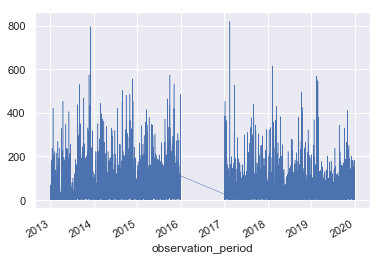

In [41]:
df_single['DEHH064_NO_dataGroup1'].plot(linewidth=0.5);

In [42]:
df_single.dtypes

DEHH073_NO_dataGroup1     float64
DEHH008_O3_dataGroup1     float64
DEHH059_NOx_dataGroup1    float64
DEHH073_NO2_dataGroup1    float64
DEHH016_PM1_dataGroup1    float64
                           ...   
DEHH059_SO2_dataGroup1    float64
DEHH033_NO2_dataGroup1    float64
DEHH064_NO2_dataGroup1    float64
DEHH015_NO2_dataGroup1    float64
DEHH050_NO2_dataGroup1    float64
Length: 68, dtype: object

In [43]:
df_single.index

DatetimeIndex(['2013-01-01 00:00:00+01:00', '2013-01-01 01:00:00+01:00',
               '2013-01-01 02:00:00+01:00', '2013-01-01 03:00:00+01:00',
               '2013-01-01 04:00:00+01:00', '2013-01-01 05:00:00+01:00',
               '2013-01-01 06:00:00+01:00', '2013-01-01 07:00:00+01:00',
               '2013-01-01 08:00:00+01:00', '2013-01-01 09:00:00+01:00',
               ...
               '2019-12-31 14:00:00+01:00', '2019-12-31 15:00:00+01:00',
               '2019-12-31 16:00:00+01:00', '2019-12-31 17:00:00+01:00',
               '2019-12-31 18:00:00+01:00', '2019-12-31 19:00:00+01:00',
               '2019-12-31 20:00:00+01:00', '2019-12-31 21:00:00+01:00',
               '2019-12-31 22:00:00+01:00', '2019-12-31 23:00:00+01:00'],
              dtype='datetime64[ns, pytz.FixedOffset(60)]', name='observation_period', length=52560, freq=None)

In [44]:
df_day_year = df_single
df_day_year['date'] = pd.to_datetime(df_day_year.index)
df_day_year['year'] = df_day_year['date'].dt.year
df_day_year['day'] = df_day_year['date'].dt.dayofyear

In [45]:
df_day_year

,DEHH073_NO_dataGroup1,DEHH008_O3_dataGroup1,DEHH059_NOx_dataGroup1,DEHH073_NO2_dataGroup1,DEHH016_PM1_dataGroup1,DEHH016_NO_dataGroup1,DEHH079_NO_dataGroup1,DEHH050_NOx_dataGroup1,DEHH015_SO2_dataGroup1,DEHH072_NOx_dataGroup1,...,DEHH033_CO_dataGroup1,DEHH008_NO2_dataGroup1,DEHH059_SO2_dataGroup1,DEHH033_NO2_dataGroup1,DEHH064_NO2_dataGroup1,DEHH015_NO2_dataGroup1,DEHH050_NO2_dataGroup1,date,year,day
observation_period,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+01:00,2.0,37.517,10.063,6.143,10.794,2.000,2.00,15.387,5.577,6.137,...,0.23456,34.333,16.109,12.498,32.411,15.839,10.407,2013-01-01 00:00:00+01:00,2013,1
2013-01-01 01:00:00+01:00,2.0,45.731,10.063,6.143,21.090,2.000,2.00,3.060,2.500,3.060,...,0.24292,26.471,2.500,11.702,29.808,8.469,4.094,2013-01-01 01:00:00+01:00,2013,1
2013-01-01 02:00:00+01:00,2.0,50.870,7.809,6.143,11.200,2.000,2.00,3.060,2.500,3.060,...,0.20673,19.417,2.500,9.936,28.480,9.232,2.000,2013-01-01 02:00:00+01:00,2013,1
2013-01-01 03:00:00+01:00,2.0,55.089,14.752,6.143,10.071,2.000,2.00,3.060,2.500,3.060,...,0.10000,14.176,8.025,6.366,28.407,6.735,2.000,2013-01-01 03:00:00+01:00,2013,1
2013-01-01 04:00:00+01:00,2.0,55.033,14.199,6.143,8.093,2.000,2.00,3.060,2.500,3.060,...,0.10000,12.790,10.914,4.632,26.336,7.622,2.000,2013-01-01 04:00:00+01:00,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+01:00,2.0,53.569,36.661,9.986,25.405,2.000,2.00,7.823,2.500,11.073,...,0.10000,18.548,6.883,31.095,37.350,54.225,8.188,2019-12-31 19:00:00+01:00,2019,365
2019-12-31 20:00:00+01:00,2.0,40.878,32.134,8.726,31.239,2.000,2.00,12.324,2.500,11.822,...,0.21820,29.200,8.485,27.776,58.767,53.365,12.948,2019-12-31 20:00:00+01:00,2019,365
2019-12-31 21:00:00+01:00,2.0,28.993,30.830,11.889,28.887,8.737,2.00,13.787,2.500,10.717,...,0.10000,38.042,9.448,24.601,61.504,52.547,14.205,2019-12-31 21:00:00+01:00,2019,365


## Sensor position data
The sensor IDs are encoded by *text* of **natlStationCode** and **EUStationCode** tags, and the name of municipality is in *text* of **municipality** tag. More detailed location information, like coordinates (**pos**) and elevation (**altitude**) is available.

In [57]:
# pick all tags from the XML file
Etree = etree.parse("Correlaid.rawData/DE_D_allInOne_metaMeasurements_2019.xml")
Eroot = Etree.getroot()
Eroot.tag
Eroot.attrib
AllTags = [elem.tag for elem in Eroot.iter()]
print(AllTags[23:35])

['{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}municipality', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}EUStationCode', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}stationInfo', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}areaClassification', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}altitude', '{http://www.opengis.net/gml/3.2}featureMember', '{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}AQD_SamplingPoint', '{http://inspire.ec.europa.eu/schemas/ef/3.0}inspireId', '{http://inspire.ec.europa.eu/schemas/base/3.3}Identifier', '{http://inspire.ec.europa.eu/schemas/base/3.3}localId', '{http://inspire.ec.europa.eu/schemas/base/3.3}namespace', '{http://inspire.ec.europa.eu/schemas/base/3.3}versionId']


In [58]:
varMUN = [s for s in AllTags if 'municipality' in s][0]
varID  = [s for s in AllTags if 'EUStationCode' in s][0]
varPOS  = [s for s in AllTags if 'pos' in s][0]
varFeatMem = [s for s in AllTags if 'featureMember' in s][0]


IDs = []
MUNs = []
POSs = []
LONGs = []
LATs = []

for varr in Eroot.iter(varFeatMem):
    for child in varr.iter(varMUN):
        MUNs.append(child.text)
        for child2 in varr.iter(varID):
            IDs.append(child2.text)
        for child3 in varr.iter(varPOS):
            LONGs.append(float(child3.text.split()[0]))
            LATs.append(float(child3.text.split()[1]))
            
SensorLocation = pd.DataFrame({'SensorID': IDs, 'SensorTown': MUNs, 'SensorLong': LONGs, 'SensorLat': LATs})
SensorLocation.tail(5)

,SensorID,SensorTown,SensorLong,SensorLat
876,DEUB005,Lüder,52.800773,10.756733
877,DEUB028,Zingst,54.436985,12.721938
878,DEUB029,Suhl,50.654066,10.769534
879,DEUB030,Stechlin,53.141303,13.031662
880,DEUB044,Garmisch-Partenkirchen,47.414436,10.980657


Since in the current project we are interested in the informations from measuring stations located in Hamburg,
Let' s select only ones having ID containing **DEHH** and remove duplicates:

In [59]:
SensorLocationHH = SensorLocation[SensorLocation.SensorID.str.contains("DEHH")].copy()
SensorLocationHH.drop_duplicates(inplace=True, ignore_index=True)
SensorLocationHH.tail()

,SensorID,SensorTown,SensorLong,SensorLat
17,DEHH076,Hamburg,53.467561,9.971706
18,DEHH078,Hamburg,53.551042,9.965585
19,DEHH079,Hamburg,53.545269,9.944815
20,DEHH080,Hamburg,53.547355,9.987920
21,DEHH081,Hamburg,53.529158,9.981599


We can see, that the list contains information on **21** measuring stations.

In [60]:
SensorLocationHH.to_csv("SensorLocationHH.csv")

# Selected measuring stations related to Diesel Ban:
Diesel ban in Hamburg (happened on 30.06.2017 targeted on reduce of NO2 emission, ban area is limited by Max-Brauer-Allee: between Julius-Leber-Straße/Max-Brauer-Allee and Holstenstraße/Max-Brauer-Allee, ca. 580 m (**DEHH070** station, data available for all yars except 2016); Stresemannstraße: between Kaltenkircher Platz/Stresemannstraße and Neuer Pferdemarkt, ca. 1.600 m (**DEHH064** and **DEHH026**, data available))

In [46]:
df_day_year.columns

Index(['DEHH073_NO_dataGroup1', 'DEHH008_O3_dataGroup1',
       'DEHH059_NOx_dataGroup1', 'DEHH073_NO2_dataGroup1',
       'DEHH016_PM1_dataGroup1', 'DEHH016_NO_dataGroup1',
       'DEHH079_NO_dataGroup1', 'DEHH050_NOx_dataGroup1',
       'DEHH015_SO2_dataGroup1', 'DEHH072_NOx_dataGroup1',
       'DEHH008_NOx_dataGroup1', 'DEHH016_NOx_dataGroup1',
       'DEHH064_NOx_dataGroup1', 'DEHH079_NOx_dataGroup1',
       'DEHH068_NO2_dataGroup1', 'DEHH072_PM1_dataGroup1',
       'DEHH073_NOx_dataGroup1', 'DEHH070_NOx_dataGroup1',
       'DEHH072_NO2_dataGroup1', 'DEHH059_PM2_dataGroup1',
       'DEHH068_CO_dataGroup1', 'DEHH033_O3_dataGroup1',
       'DEHH070_NO_dataGroup1', 'DEHH079_SO2_dataGroup1',
       'DEHH079_PM1_dataGroup1', 'DEHH015_NOx_dataGroup1',
       'DEHH008_PM1_dataGroup1', 'DEHH059_NO2_dataGroup1',
       'DEHH070_PM1_dataGroup1', 'DEHH047_NO_dataGroup1',
       'DEHH008_SO2_dataGroup1', 'DEHH070_NO2_dataGroup1',
       'DEHH008_PM2_dataGroup1', 'DEHH070_CO_dataGroup1',
      

In [47]:
df_day_year_DB = df_day_year[['DEHH026_NO_dataGroup1', 'DEHH064_NO_dataGroup1', 'DEHH070_NO_dataGroup1', 'year', 'day']]

In [48]:
df_day_year_DB

,DEHH026_NO_dataGroup1,DEHH064_NO_dataGroup1,DEHH070_NO_dataGroup1,year,day
observation_period,,,,,
2013-01-01 00:00:00+01:00,16.626,17.011,26.967,2013,1
2013-01-01 01:00:00+01:00,2.000,15.236,24.407,2013,1
2013-01-01 02:00:00+01:00,2.000,13.308,30.741,2013,1
2013-01-01 03:00:00+01:00,2.000,11.746,21.551,2013,1
2013-01-01 04:00:00+01:00,2.000,10.358,17.148,2013,1
...,...,...,...,...,...
2019-12-31 19:00:00+01:00,22.398,18.949,41.727,2019,365
2019-12-31 20:00:00+01:00,10.546,29.696,43.461,2019,365
2019-12-31 21:00:00+01:00,12.187,34.267,50.880,2019,365


In [49]:
df_day_year_DB['24h_rolling_avg_NO26'] = df_day_year_DB["DEHH026_NO_dataGroup1"].rolling(24).mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
df_day_year_DB['1w_rolling_avg_NO26'] = df_day_year_DB["DEHH026_NO_dataGroup1"].rolling(168).mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
df_day_year_DB['1m_rolling_avg_NO26'] = df_day_year_DB["DEHH026_NO_dataGroup1"].rolling(5124).mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
df_day_year_DB['1m_rolling_avg_NO64'] = df_day_year_DB["DEHH064_NO_dataGroup1"].rolling(5124).mean()
df_day_year_DB['1m_rolling_avg_NO70'] = df_day_year_DB["DEHH070_NO_dataGroup1"].rolling(5124).mean()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
df_day_year_DB

,DEHH026_NO_dataGroup1,DEHH064_NO_dataGroup1,DEHH070_NO_dataGroup1,year,day,24h_rolling_avg_NO26,1w_rolling_avg_NO26,1m_rolling_avg_NO26,1m_rolling_avg_NO64,1m_rolling_avg_NO70
observation_period,,,,,,,,,,
2013-01-01 00:00:00+01:00,16.626,17.011,26.967,2013,1,NaN,NaN,NaN,NaN,NaN
2013-01-01 01:00:00+01:00,2.000,15.236,24.407,2013,1,NaN,NaN,NaN,NaN,NaN
2013-01-01 02:00:00+01:00,2.000,13.308,30.741,2013,1,NaN,NaN,NaN,NaN,NaN
2013-01-01 03:00:00+01:00,2.000,11.746,21.551,2013,1,NaN,NaN,NaN,NaN,NaN
2013-01-01 04:00:00+01:00,2.000,10.358,17.148,2013,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+01:00,22.398,18.949,41.727,2019,365,9.620292,19.831298,21.214906,39.171358,30.386633
2019-12-31 20:00:00+01:00,10.546,29.696,43.461,2019,365,9.786125,19.822238,21.216574,39.173476,30.391549
2019-12-31 21:00:00+01:00,12.187,34.267,50.880,2019,365,9.959708,19.798679,21.217830,39.176953,30.397733


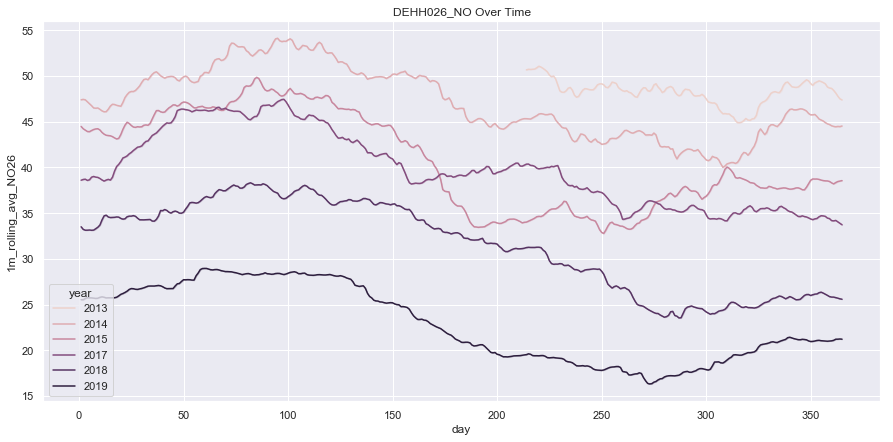

In [54]:
#sns.palplot(sns.color_palette("husl", 8))
plt.figure(figsize=(15, 7))
NO_26 = sns.lineplot(
    x="day",
#    y="DEHH064_NO_dataGroup1",
    y="1m_rolling_avg_NO26",
    hue="year",
    data=df_day_year_DB
).set_title('DEHH026_NO Over Time')
plt.show()

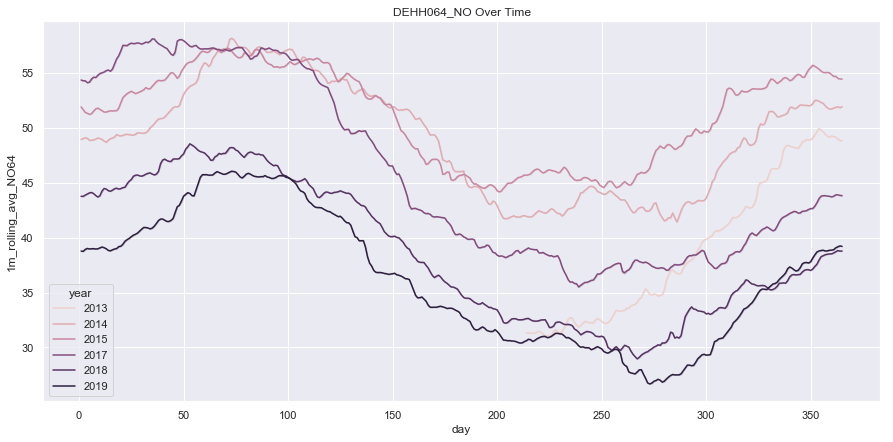

In [55]:
plt.figure(figsize=(15, 7))
NO_64 = sns.lineplot(
    x="day",
    y="1m_rolling_avg_NO64",
    hue="year",
    data=df_day_year_DB
).set_title('DEHH064_NO Over Time')
plt.show()

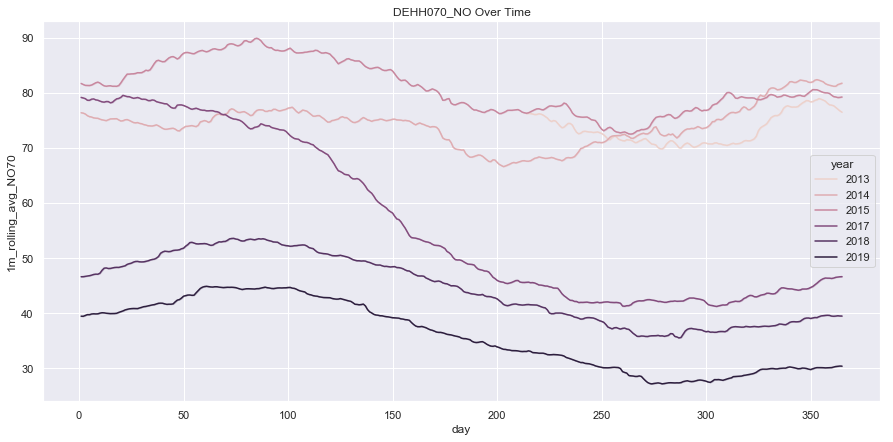

In [56]:
plt.figure(figsize=(15, 7))
NO_70 = sns.lineplot(
    x="day",
    y="1m_rolling_avg_NO70",
    hue="year",
    data=df_day_year_DB
).set_title('DEHH070_NO Over Time')
plt.show()

The effect of Diesel Ban is most pronounced at Julius-Leber-Straße/Max-Brauer-Allee close to **DE_HH_070** measuring station.